In [337]:
from data import mask_to_submission
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
import os 
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler


# Project Road Segmentation

For this choice of project task, we provide a set of satellite images acquired 
from GoogleMaps. We also provide ground-truth images where each pixel is labeled 
as road or background. 

Your task is to train a classifier to segment roads in these images, i.e. 
assigns a label `road=1, background=0` to each pixel.

Submission system environment setup:

1. The dataset is available from the 
[AICrowd page](https://www.aicrowd.com/challenges/epfl-ml-road-segmentation).

2. Obtain the python notebook `segment_aerial_images.ipynb` from this github 
folder, to see example code on how to extract the images as well as 
corresponding labels of each pixel.

The notebook shows how to use `scikit learn` to generate features from each 
pixel, and finally train a linear classifier to predict whether each pixel is 
road or background. Or you can use your own code as well. Our example code here 
also provides helper functions to visualize the images, labels and predictions. 
In particular, the two functions `mask_to_submission.py` and 
`submission_to_mask.py` help you to convert from the submission format to a 
visualization, and vice versa.

3. As a more advanced approach, try `tf_aerial_images.py`, which demonstrates 
the use of a basic convolutional neural network in TensorFlow for the same 
prediction task.

Evaluation Metric:
 [F1 score](https://en.wikipedia.org/wiki/F1_score)


## Example Image

(400, 400, 3) (400, 400, 3)


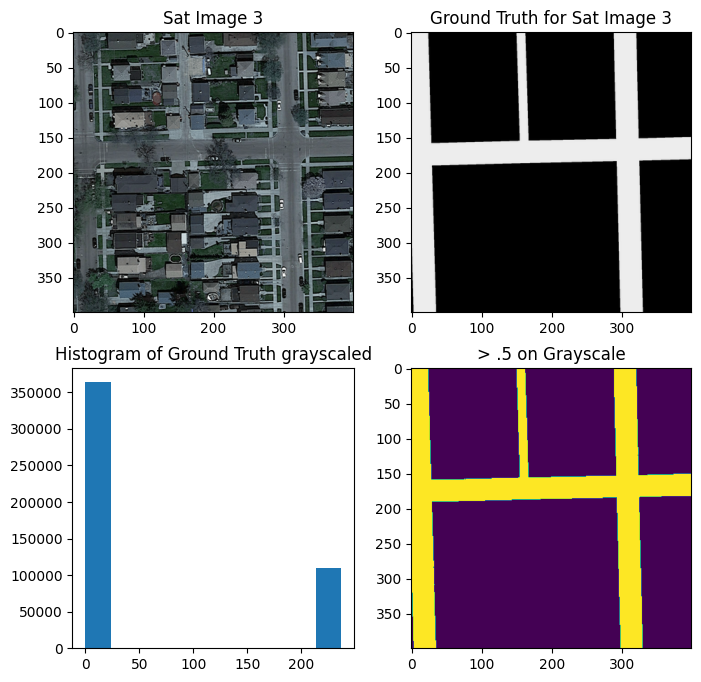

In [4]:
img_idx = 3
im = cv.imread(f'data/training/images/satImage_00{img_idx}.png')
im_gt = cv.imread(f'data/training/groundtruth/satImage_00{img_idx}.png')
im_gt_gs = np.where(color.rgb2gray(im_gt) > .5, 1, 0)

fig, ax = plt.subplots(2, 2, figsize = (8, 8))
ax[0,0].imshow(im)
ax[0,0].set_title(f"Sat Image {img_idx}")
ax[0,1].imshow(im_gt)
ax[0,1].set_title(f"Ground Truth for Sat Image {img_idx}")
ax[1,0].hist(im_gt.flatten(), bins = 10)
ax[1,0].set_title('Histogram of Ground Truth grayscaled')
ax[1,1].imshow(im_gt_gs)
ax[1,1].set_title('> .5 on Grayscale')

print(im.shape, im_gt.shape,)
plt.show()

<font size = 3> The task is **semantic segmentation**, and in this particular case binary classification of road pixels. For images this means generating a 2d mask of binary values for 1: road and 0: other pixels. To solve this task our project will use the following methods and follow this plan as a road map to success:
> <h4> 0) Helper functions
> <h4> 1) Random classification
> <h4> 2) Dummy classifier
> <h4> 3) Image processing algorithm
> <h4> 4) Classic machine learning techniques with feature vectors (Linear Regression, Logistic Regression, Decision Trees & Random Forests 
> <h4> 5) Convolutional Neural Networks
> <h4> 6) Transfer Learning

## 0) Helper functions

In [395]:
def metrics(y_pred, y, significant_digits = 5):
    """"
    Function evaluates models for binary classification tasks
    Inputs are 2 1D numpy arrays
    y_pred is your predicted numpy array values are {0, 1}
    y is the actual labels/ground truth values, also in {0, 1}
    """
    TP, TN, FP, FN = (0 for i in range(4))
    TP = sum(y_pred + y > 1)
    TN = sum(y_pred + y == 0)
    FP = sum(y_pred) - TP
    FN = sum(y) - TP
    
    if (TP+FP != 0):
        P = TP/(TP+FP)
    else:
        P = 0 
    
    if (TP+FN != 0):
        R = TP/(TP+FN)  
    else:
        R = 0

    if (P+R != 0):
        F1 = 2*(P*R)/(P+R)
    else: 
        F1 = 0
    metric_formulas = {"Accuracy": round((TP + TN)/(TP + TN + FP + FN), significant_digits), "Precision": round(P, significant_digits),
                        "Recall": round(R, significant_digits), "F1-score":round(F1, significant_digits)}
    return metric_formulas

def parse_mask_to_binary(input_mask, grayscale_threshold = 0.5):
    """ 
    Function that takes an RGB mask and outputs the corresponding binary mask
    """
    binary_mask = np.where(color.rgb2gray(input_mask) == 0, 0, 1)
    return binary_mask

## 1) Random Classifier

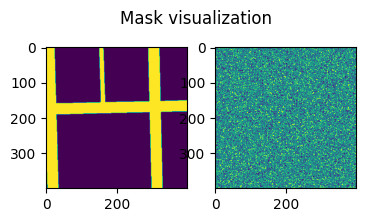

{'Accuracy': 0.4985625,
 'Precision': 0.2327914259691325,
 'Recall': 0.49891702542984734,
 'F1-score': 0.31745869702074087}

In [6]:
#Fixed seed
np.random.seed(7)

def RandomClassifier(input_img):
    output_mask = (np.random.rand(input_img.shape[0],input_img.shape[1]) > 0.5) * 255
    return color.gray2rgb(output_mask)

#No need to generalize to the whole dataset, we simply calculate the accuracy for 1 image
predicted_mask = parse_mask_to_binary( RandomClassifier(im))

fig, ax = plt.subplots(1, 2, figsize = (4, 8))
ax[0].imshow(im_gt_gs)
ax[1].imshow(predicted_mask)
fig.suptitle("Mask visualization", y = 0.63)
plt.show() 

metrics(y_pred = predicted_mask.flatten(), y = im_gt_gs.flatten())

So as hypothesized, the random classifier has an accuracy of ~50%, and this is the case of a single image from the training set where we luckily have a similar number of road/background pixels ratio = 1. This is a nice benchmark to understand the dataset and compare our models to, but nothing else.

## 2) Dummy Classifier

What is a dummy classifier in our case? Well, one could see it as an emperical statistical estimation of what a road pixel should look like and then classifying all pixels through this condition.

One of the most straight forward dummy classifiers we can make is to take a look at our image's color histograms and deduce an empiricala condition on this.

We have 3 different channels per image R, G, B. but since roads are mostly gray, we can take a look at at a computed hue or HSV channel or even just the grayscale channel

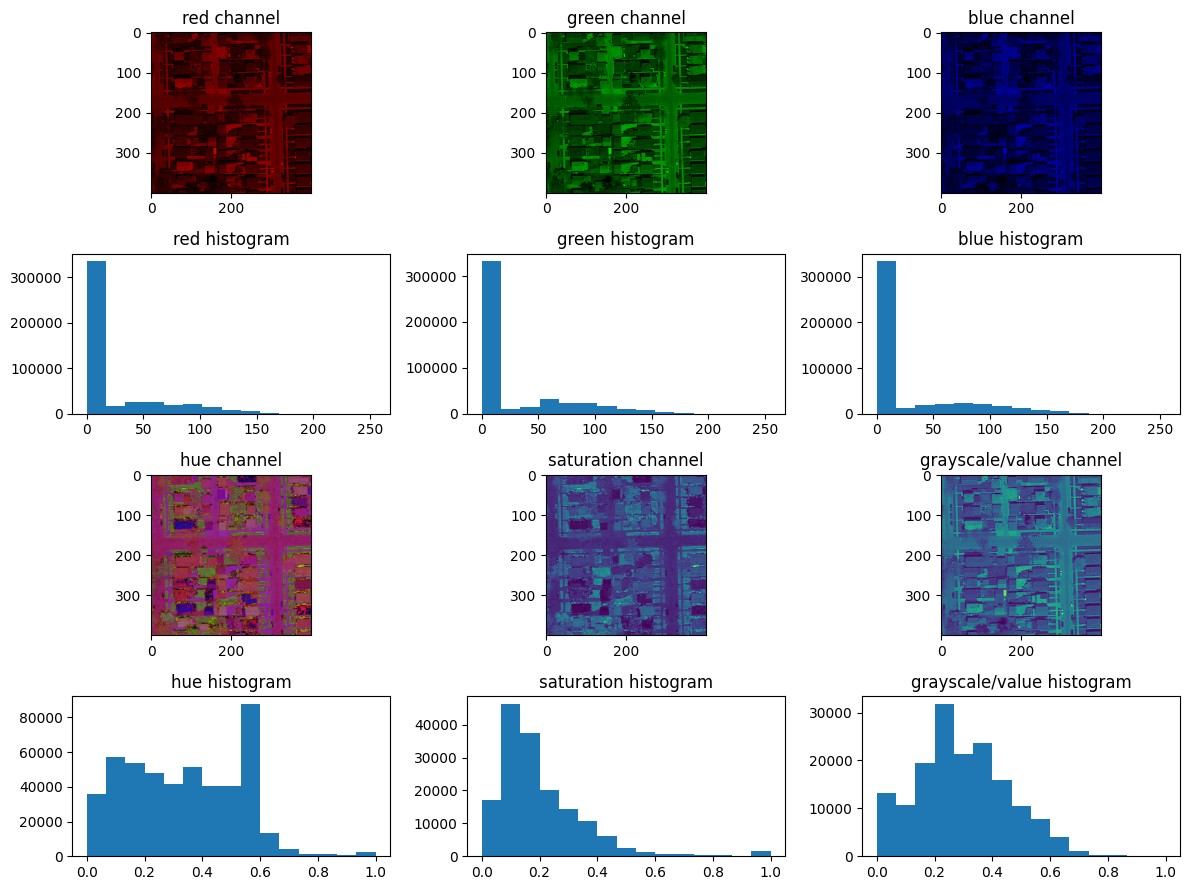

In [7]:
im_red_channel = im.copy()
im_red_channel[:, :, 1] = 0
im_red_channel[:, :, 2] = 0

im_green_channel = im.copy()
im_green_channel[:, :, 0] = 0
im_green_channel[:, :, 2] = 0

im_blue_channel = im.copy()
im_blue_channel[:, :, 0] = 0
im_blue_channel[:, :, 1] = 0

im_hsv = color.rgb2hsv(im)
im_hue_channel = im_hsv[:, :, 0]
im_saturation_channel = im_hsv[:, :, 1]

im_grayscale = color.rgb2gray(im)


channels = {"red": im_red_channel, "green": im_green_channel, "blue": im_blue_channel, "hue": im_hsv, "saturation": im_saturation_channel,
            "grayscale/value": im_grayscale}

fig, ax = plt.subplots(4, 3, figsize = (12, 9)) 
#Channels: 0, 1, 2, 3, 4, 5
#Plots rows : 0, 0, 0, 2, 2
for kdx, key in enumerate(channels):
    ax[2*int(kdx/3), kdx%3].imshow(channels[key])
    ax[2*int(kdx/3), kdx%3].set_title(key + " channel")

    ax[2*int(kdx/3) + 1, kdx%3].hist(channels[key].flatten(), bins = 15)
    ax[2*int(kdx/3) + 1, kdx%3].set_title(key + " histogram")

#fig.delaxes(ax[2, 2])
#fig.delaxes(ax[3, 2])
plt.tight_layout()
plt.show()


What we can see is that there are no histogram peaks or bumps for our road pixel values and this is a clear challenge in our task, as the satellite images are taken from a bird's eye view, the house roof's are also gray and of very similar color to the roads, which makes it hard to discern valid barriers. 
None the less in our HSV histograms, we seem to have a certain peak at around .15 for the saturation channel, lets see if this generalizes to the rest of the training set.


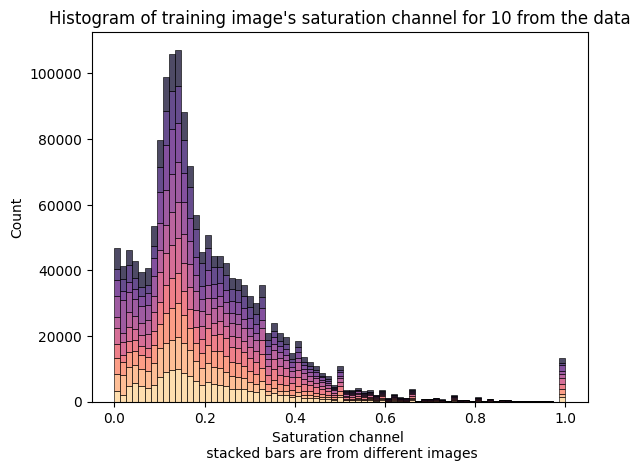

In [8]:
hue_images = []
n_images = 10 #Take n images as to not overload memory
TRAINING_DIR = "data/training/images/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR)): training_images = sorted(files)

for img_name in training_images[:n_images]: 
    img = cv.imread(TRAINING_DIR+img_name)
    hue_images.append(color.rgb2hsv(img)[:,:, 1].flatten()) #Extractng flattened hue pixel values

#hue_images = np.concatenate(hue_images)
sns.histplot(hue_images, bins = 75, palette = sns.color_palette("magma", n_colors=n_images), multiple='stack', legend=False)
plt.title(f"Histogram of training image's saturation channel for {n_images} from the data")
plt.xlabel("Saturation channel \n stacked bars are from different images")
plt.show()


So there seems to be a generalizable trend for our dummy classifier of a peak of values from 0.1 to 0.2 in saturation values, lets make the classifier and evaluate it's performance

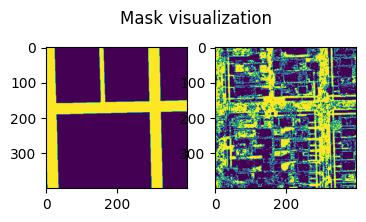

{'Accuracy': 0.672731875,
 'Precision': 0.4004346592060982,
 'Recall': 0.6159361357116129,
 'F1-score': 0.4853389684743348}

In [9]:
def DummyClassifier(input_img):
    saturation_channel = color.rgb2hsv(input_img)[:, :, 1]
    output_mask = np.where((saturation_channel > 0.1) & (saturation_channel < 0.2), 1, 0)
    return output_mask

TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_images = sorted(files)
n_images = 10 #Take n images as to not overload memory

sum_labels = [[], []]
for file_name in training_images[:n_images]:
    img = cv.imread(TRAINING_DIR+'images/'+file_name)
    
    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file_name)
    predicted_mask = DummyClassifier(img)

    sum_labels[0].append(predicted_mask.flatten())
    sum_labels[1].append(parse_mask_to_binary(groundtruth_mask).flatten())

y_pred = np.concatenate(sum_labels[0])
y = np.concatenate(sum_labels[1])

predicted_mask = DummyClassifier(im)

fig, ax = plt.subplots(1, 2, figsize = (4, 8))
ax[0].imshow(im_gt_gs)
ax[1].imshow(predicted_mask)
fig.suptitle("Mask visualization", y = 0.63)
plt.show() 

metrics(y_pred, y)

So these average metrics are already better scores than the random classifier which is nice.

## 3) Image processing algorithm

Having taken a look at the histograms for our dummy classifier, this got us thinking what other image properties and methods we could use. Before neural networks, semantic segmentation worked through smart region growing algorithms with similar pixels of interest. These are methods could work for our task too.

## 4) Classic machine learning techniques
#### i) Feature extraction
#### ii) Linear Regression
#### iii) Logistic Regression
#### iv) Decision Tree/SVM/Forest (don't know which one, Nearest neighbors?)

### i) Feature extraction

Images has always been a tricky task for machine learning techniques and thats mainly the image to feature translation task that isn't obvious. In normal linear regression, you input a feature vector of a sample and obtain an output whether that be a classification or regression value to vector. For linear regression you simple cant input a 2d image as an input for a plethora of reasons. The main one being ambiguous dimensions, but also the if the features are simply the pixel values as a flattened vector, we lose our contextual information of the pixel.

In the provided code, we have a feature generation method, based on our RGB channels by dividing our images in linear patches and then infering features from those patches. This is great as we can assume through data inspection that our roads have a minimum width and this saves us alot of computational time. 

Here we will try a different avenue of pixel feature generation and perhaps quickly see that this is not viable. (limitations no shape/fourier descriptors) 

In [227]:
def img_to_patches(img, number_of_patches, print_=False):
    """
    Function that takes full size image and outputs a list of the image's patches
    number of patches divides the image into number of those patches
    """
    patches_per_dimension = np.sqrt(number_of_patches)
    #assert img.shape[0]%patches_per_dimension== 0 & img.shape[1]%patches_per_dimension == 0
    
    patch_width, patch_height = (int(img.shape[0]/patches_per_dimension), int(img.shape[1]/patches_per_dimension))
    list_of_patches = []

    for i in range(number_of_patches):
        x = int(i/patches_per_dimension)*patch_width
        y = int((i%patches_per_dimension)*patch_height)
        list_of_patches.append(
            img[x:x+patch_width, y:y+patch_height]
        )
    if (print_): print("patch dim", patch_width, patch_height)
    return list_of_patches

def patch_to_features(patch, n_features=20):
    """ 
    Function that takes in 2d patch of an RGB image as an input and outputs a feature vector for this patch
    """
    #supposing patches come in RGB
    feature_vector = []
    patch_hsv = color.rgb2hsv(patch)
    concatenated_channels = np.concatenate([patch, patch_hsv], axis=2)
    n_channels = concatenated_channels.shape[2]
    
    for cdx in range(n_channels): #With expected R,G,B,H,S,V channels this gives us 12 features per patch already
        feature_vector.append(np.mean(concatenated_channels[:, :, cdx].flatten()))
        feature_vector.append(np.std(concatenated_channels[:, :, cdx].flatten()))
    
    #Texture features

    #Create bank of gabor filters 

    #Convolution and take middle pixel?? bruh momento

    return feature_vector

def groundtruth_patch_to_label(patch, foreground_threshold = .5):
    """
    Takes patch from mask and computes average label value
    likeliness of patch to be road or background
    """
    return int(np.mean(patch.flatten()) > foreground_threshold)

def predicted_patch_labels_to_mask(labels, output_shape): #array 1d, tuple (2)
    """
    Takes array of patch labels and converts it into binary mask :)
    """
    mask = np.zeros(output_shape)

    patches_per_dimension = np.sqrt(len(labels))
    patch_width, patch_height = (int(output_shape[0]/patches_per_dimension), int(output_shape[1]/patches_per_dimension))
    for ldx, l in enumerate(labels): 
        x = int(ldx/patches_per_dimension)*patch_width
        y = int((ldx%patches_per_dimension)*patch_height)
        
        mask[x:x+patch_width, y:y+patch_height] = l
        
    return mask 

def visualize_predicition(img, gt, scaler, model, n_patches):
    """
    Takes model and scaler and runs pipeline on an image and plots it versus the groundtruth 
    """
    output_shape = gt.shape

    patches = img_to_patches(img, number_of_patches=n_patches)
    features = scaler.transform(np.array([patch_to_features(patch) for patch in patches]))
    
    predicition_patches = model.predict(features)
    img_mask = predicted_patch_labels_to_mask(predicition_patches, output_shape)

    fig, ax = plt.subplots(1, 2, figsize = (4, 8))
    ax[0].imshow(gt)
    ax[1].imshow(img_mask)
    fig.suptitle("Visualization and metrics for 1 mask", y = 0.63)
    plt.show()

    #Get image metrics 
    gt_patches = img_to_patches(gt, n_patches)
    labels_patches = np.array([groundtruth_patch_to_label(patch,) for patch in gt_patches])

    return metrics(predicition_patches, labels_patches)

def mask_predictions(scaler, model, n_patches, img_directory, gt_directory, dataset_size=100):

    for root, dirs, files in sorted(os.walk(img_directory)): image_filenames = sorted(files)
    
    AICROWD_PATCHSIZE = 16
    avg_metrics = {'Accuracy': 0, 'F1-score': 0}
    for file in image_filenames[:dataset_size]:

        img = cv.imread(img_directory+'/'+file)
        gt = cv.imread(gt_directory+'/'+file)

        #Patch the input image and generate predictions for patches
        img_patches = img_to_patches(img, number_of_patches=n_patches)
        img_features = scaler.transform(np.array([patch_to_features(patch) for patch in img_patches]))
        predicition_img_patches = model.predict(img_features)

        #reconstruct from predicted patch labels a mask
        predicted_mask = predicted_patch_labels_to_mask(predicition_img_patches, output_shape=img.shape)

        #get groundtruth patches and mask like AICrowd submissions
        n_patches_gt = int((gt.shape[0]/AICROWD_PATCHSIZE)**2)
        gt_patches = img_to_patches(gt, number_of_patches=n_patches_gt)
        labels_patches = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in gt_patches])
        gt_patched_mask = predicted_patch_labels_to_mask(labels_patches, gt.shape)

        file_metrics = metrics(predicted_mask.flatten(), gt_patched_mask.flatten())
        avg_metrics['Accuracy'] += file_metrics['Accuracy']
        avg_metrics['F1-score'] += file_metrics['F1-score']

    avg_metrics['Accuracy'] /= len(image_filenames[:dataset_size])
    avg_metrics['F1-score'] /= len(image_filenames[:dataset_size])
    return avg_metrics

##### Now we will create our training dataset of with just our patches and train our classifiers with this patch feature dataset

In [199]:
TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_data = []
n_patches = 16*16
n_images = 10
for fdx, file in enumerate(training_filenames):

    #patch features
    img = cv.imread(TRAINING_DIR+'images/'+file)
    img_patches = img_to_patches(img, number_of_patches=n_patches)
    patches_features = np.array([patch_to_features(patch) for patch in img_patches])
    
    #patch labels
    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    mask_patches = img_to_patches(groundtruth_mask, number_of_patches=n_patches)
    mask_labels = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in mask_patches])

    img_data = np.concatenate([patches_features, mask_labels.reshape(-1, 1)], axis = 1)
    if (fdx%10 == 0): print('img number:', fdx)
    training_data.append(img_data)

training_df = pd.DataFrame(np.concatenate(training_data))

print("final dataframe shape:", training_df.shape) #should be (n_images*n_patches, n_features + 1) #without gabor filters n_features = 12 
training_df.to_csv('data/derivatives/training_data_custom.csv') #save for later use to not run spaghetti code again

img number: 0
img number: 10
img number: 20
img number: 30
img number: 40
img number: 50
img number: 60
img number: 70
img number: 80
img number: 90
final dataframe shape: (25600, 13)


In [228]:
training_df = pd.read_csv('data/derivatives/training_data_custom.csv', index_col=0)

scaler = StandardScaler()
training_df.iloc[:, :-1] = scaler.fit_transform(training_df.iloc[:, :-1].values)
display(training_df.sample())

X, y = (training_df.iloc[:, :-1], training_df.iloc[:, -1])

,0,1,2,3,4,5,6,7,8,9,10,11,12
13831,-0.108991,0.441331,-0.111324,0.511829,-0.057698,0.708747,0.169322,0.712967,0.023806,0.54774,-0.080305,0.641335,1.0


So now we have extracted our features for our training data, we can start looking at our models and evaluating ***training and validation metrics*** for our models

One more note is that cross validation is great for fine tuning, however, we hypothesize that our best model will include CNNs, so we will content ourselves with estimating validation metrics on a train-validation split.

In [202]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15)

### ii) Linear Regression

Good ol' linear regression. Let's see how well it does, for this part we'll be using sklearn's SGD Classifier to cycle through classic ML models that we saw for project 1.

Training patches average: {'Accuracy': 0.66742, 'Precision': 0.58856, 'Recall': 0.52438, 'F1-score': 0.55462} 

Validation patches average: {'Accuracy': 0.68307, 'Precision': 0.59214, 'Recall': 0.56203, 'F1-score': 0.5767} 

Predicted mask average (on "whole" training set): {'Accuracy': 0.7401060000000002, 'F1-score': 0.618784}


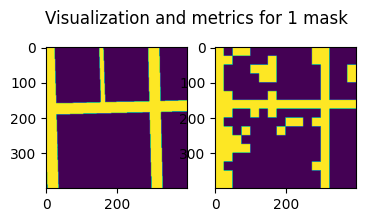

{'Accuracy': 0.875,
 'Precision': 0.67089,
 'Recall': 0.89831,
 'F1-score': 0.76812}

In [240]:
n_epochs = 1000
linear_classifier = SGDClassifier(loss='squared_error', max_iter=n_epochs, tol=1e-12)
linear_classifier.fit(X_train.values,y_train.values)

training_predictions = linear_classifier.predict(X_train.values)
validation_predictions = linear_classifier.predict(X_validation.values) #difference between patch and mask accuracy

print('Training patches average:', metrics(training_predictions, y_train), '\n')
print('Validation patches average:', metrics(validation_predictions, y_validation), '\n')

print('Predicted mask average:', mask_predictions(scaler=scaler, model=linear_classifier, n_patches=n_patches,
        img_directory="data/training/images", gt_directory="data/training/groundtruth", dataset_size=10))

#visualization for a sample
visualize_predicition(im, im_gt_gs, scaler=scaler, model=linear_classifier,n_patches=n_patches)


Patch size has huge influence and results are quite variable, however we can clearly see a great improvement from our dummy classifier, the predicted mask average accuracy ~74% and F1-score ~61%.

### iii) Logistic Regression


Training patches average: {'Accuracy': 0.69991, 'Precision': 0.65891, 'Recall': 0.49773, 'F1-score': 0.56709} 

Validation patches average: {'Accuracy': 0.71589, 'Precision': 0.66552, 'Recall': 0.52339, 'F1-score': 0.58596} 

Predicted mask average (on "whole" training set): {'Accuracy': 0.7446010000000001, 'F1-score': 0.620268}


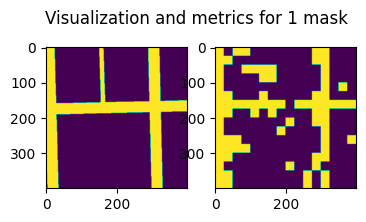

{'Accuracy': 0.84766,
 'Precision': 0.625,
 'Recall': 0.84746,
 'F1-score': 0.71942}

In [238]:
n_epochs = 100000
logistic_regression= SGDClassifier(loss='log_loss', max_iter=n_epochs, tol=1e-12)
logistic_regression.fit(X_train.values,y_train.values)

training_predictions = logistic_regression.predict(X_train.values)
validation_predictions = logistic_regression.predict(X_validation.values)

print('Training patches average:', metrics(training_predictions, y_train), '\n')
print('Validation patches average:', metrics(validation_predictions, y_validation), '\n')

print('Predicted mask average:', mask_predictions(scaler=scaler, model=logistic_regression, n_patches=n_patches,
        img_directory="data/training/images", gt_directory="data/training/groundtruth", dataset_size=10))

visualize_predicition(im, im_gt_gs, scaler=scaler, model=logistic_regression,n_patches=n_patches)

Logistic regression outperforms linear regression on the patch accuracy and mask accuracy. To be expected.

### iv) Try one last model, ideas: Random forests, SVM, k-NN with cool distance metrics (cosine distance)

### v) Performance statistics & visualization
bar plot of performance recap of each model & accuracy depending on patch size

## 5) Convolutional Neural Networks

Well time to roll up our sleeves.
CNNs leverage convolutional layers to automatically and adaptively learn spatial hierarchies of features from the input data.
Convolution involves applying a set of filters (kernels) to the input image, sliding them across the image, and computing dot products at each location.
The result of the convolution operation is a set of feature maps. Each feature map represents the activation of a particular filter and highlights specific patterns or features present in our satellite images.

Instead of having an ansatz on deciding which filters we're going to use to generate feature vectors, we will learn the filters. cool beans

To custom design & test CNN architectures, we will use pytorch api and library.

> #### i) Classic CNN. VGG16 https://en.wikipedia.org/wiki/AlexNet
> #### ii) U-Net CNN. https://arxiv.org/pdf/1505.04597.pdf
> #### iii) Data Augmentation (with re-evaluation of FCN & U-Net)
> > ##### a) Dataset complementation with Masachussetts or DeepGlobe
> > ##### b) Data Augmentation (Rotating, Flipping, Crop & Resize, Gaussian Noise and other generated Corruptions)
> > ##### c) Adversarial Learning
> > ##### d) Re-evaluation of VGG16 & U-net
> #### iv) Favorite Model Fine-tuning & architecture variations

### i) Classic CNN, VGG-16

The first type of CNNs we'll explore are the classic CNNs used for image classification. We will use their CNN backbone architecture to create nice features for our image. Our task, however, is image segmentation so to adapt the traditional CNN-backbone into a full connected network used for image classification, we will treat our image segmentation as patch-wise image classification.

We know that the Aircrowd submission takes 16x16 patches of our mask as a submission, so we will do the same for our patch-wise classification.

Finally, for the CNN-backbone, there are many well known examples: LeNet, AlexNet, VGG16, GoogLeNet and the ResNet architectures. 
We will inspire ourselves off of the **VGG16** CNN architecture.

In [391]:
def img_to_patches_fixed(img, patch_size, print_=False):
    """
    Function that takes full size image and outputs a list of the image's patches
    with a fixed patch_size, needs a square image, divisible by patch size
    """
    
    patches_per_dimension = int((img.shape[0]/patch_size))
    number_of_patches = int((img.shape[0]/patch_size)**2)
    list_of_patches = []

    for i in range(number_of_patches):
        x = int(i/patches_per_dimension)*patch_size
        y = int((i%patches_per_dimension)*patch_size)
        list_of_patches.append(
            img[x:x+patch_size, y:y+patch_size]
        )
    if (print_): print("patch dim", patch_size)
    return list_of_patches

class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()

        layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.Convolutional_Layers = nn.ModuleList([layer1, layer2, layer3, layer4, layer5, 
                                                  layer6, layer7, layer8, layer9, layer10]) #VGG13 because we have 1d tensor at some point
        fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1*1*512, 4096),
            nn.ReLU())
        fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        fc3= nn.Sequential(
            nn.Linear(4096, num_classes),
            nn.Sigmoid())
        
        self.Fully_Connected = nn.ModuleList([fc1, fc2, fc3])

    def forward(self, x):

        for ldx, layer in enumerate(self.Convolutional_Layers):

            x = layer(x)
        
        y = x.reshape(x.size(0), -1)

        for ldx, layer in enumerate(self.Fully_Connected):
            y = layer(y)

        return y
    
def PatchPred(prediction):
    return np.array(torch.argmax(prediction, dim = 1).detach().numpy())

class identity:
    def __init__(self) -> None:
        pass
    def transform(self, x):
        return x

def train_model(X, y, config):

    model_dict = {"VGG16": VGG16}
    optimizer_dict = {"AdamW": optim.AdamW}
    loss_function_dict = {"CrossEntropy": nn.CrossEntropyLoss}
    prediction_transform_dict = {"PatchPred": PatchPred}

    model = model_dict[config['model']]() #Get model
    optimizer = optimizer_dict[config['optimizer']](model.parameters(), lr = config['learning_rate']) #Get optimizer
    criterion = loss_function_dict[config['loss_function']]() #Get loss function
    prediction_transform = prediction_transform_dict[config['prediction_transform']]

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15, shuffle=True) #Split data
    print("X_train shape:", X_train.shape, y_train.shape)

    #sub-sampling dataset
    subsample_size = 512

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)) 
    train_indices = list(range(len(train_dataset)))
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'])#, sampler = SubsetRandomSampler(train_indices[:subsample_size])) #create train data loader 
    
    validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(y_validation, dtype=torch.float32))
    validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=True) #create

    n_epochs = config['n_epochs'] #Training Loop Start
    for epoch in range(n_epochs):

        #Model training
        model.train() 
        train_metrics = {'Accuracy': 0, 'F1-score': 0}
        total_train_loss = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs = torch.permute(inputs, (0, 3, 2, 1)) #batch_size, channels, width, height
            prediction = model(inputs)
            loss = criterion(prediction, labels.long())
            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            prediction_class = prediction_transform(prediction)
            labels = np.array(labels.detach().numpy())
            batch_metrics = metrics(prediction_class, labels)
            train_metrics['Accuracy'] += batch_metrics['Accuracy']
            train_metrics['F1-score'] += batch_metrics['F1-score']
        
        train_metrics['Accuracy'] /= len(train_loader)
        train_metrics['F1-score'] /= len(train_loader)
        average_train_loss = total_train_loss/len(train_loader)
    
        if (epoch + 1) % 1 == 0:
            model.eval()
            validation_metrics = {'Accuracy': 0, 'F1-score': 0}
            total_validation_loss = 0
            for validation_inputs, validation_labels in validation_loader:
                with torch.no_grad():

                    validation_inputs = torch.permute(validation_inputs, (0, 3, 2, 1))
                    prediction = model(validation_inputs)
                    validation_loss = criterion(prediction, validation_labels.long())
                    total_validation_loss += validation_loss.item()

                    prediction_class = prediction_transform(prediction)
                    validation_labels = np.array(validation_labels.detach().numpy())
                    batch_metrics = metrics(prediction_class, validation_labels)
                    validation_metrics['Accuracy'] += batch_metrics['Accuracy']
                    validation_metrics['F1-score'] += batch_metrics['F1-score']
            
            validation_metrics['Accuracy'] /= len(validation_loader)
            validation_metrics['F1-score'] /= len(validation_loader)
            average_validation_loss = total_validation_loss/len(validation_loader)

            print('Epoch:', '%03d' % (epoch + 1), 'train loss =', '{:.6f}'.format(average_train_loss),
                   'val loss =', '{:.6f}'.format(average_validation_loss),'train accuracy =','{:.4f}'.format(train_metrics['Accuracy']),
                     'val accuracy =','{:.4f}'.format(validation_metrics['Accuracy']), 'validation F1', '{:.4f}'.format(validation_metrics['F1-score']))

    return model

def mask_predictions(scaler, model, n_patches, img_directory, gt_directory, dataset_size=100):

    for root, dirs, files in sorted(os.walk(img_directory)): image_filenames = sorted(files)
    
    AICROWD_PATCHSIZE = 16
    avg_metrics = {'Accuracy': 0, 'F1-score': 0}
    for file in image_filenames[:dataset_size]:

        img = cv.imread(img_directory+'/'+file)
        gt = cv.imread(gt_directory+'/'+file)

        #Patch the input image and generate predictions for patches
        img_patches = torch.permute(torch.tensor(np.array(img_to_patches(img, number_of_patches=n_patches)),  dtype=torch.float32), (0, 3, 2, 1))
        prediction_img_patches = model(img_patches)
        prediction_class_img_patches = PatchPred(prediction_img_patches)
        
        #reconstruct from predicted patch labels a mask
        predicted_mask = predicted_patch_labels_to_mask(prediction_class_img_patches, output_shape=img.shape)

        #get groundtruth patches and mask like AICrowd submissions
        n_patches_gt = int((gt.shape[0]/AICROWD_PATCHSIZE)**2)
        gt_patches = img_to_patches(gt, number_of_patches=n_patches_gt)
        labels_patches = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in gt_patches])
        gt_patched_mask = predicted_patch_labels_to_mask(labels_patches, gt.shape)

        file_metrics = metrics(predicted_mask.flatten(), gt_patched_mask.flatten())
        avg_metrics['Accuracy'] += file_metrics['Accuracy']
        avg_metrics['F1-score'] += file_metrics['F1-score']

    avg_metrics['Accuracy'] /= len(image_filenames[:dataset_size])
    avg_metrics['F1-score'] /= len(image_filenames[:dataset_size])
    return avg_metrics

def visualize_predicition(img, gt, scaler, model, n_patches):
    """
    Takes model and scaler and runs pipeline on an image and plots it versus the groundtruth 
    """
    output_shape = gt.shape

    img_patches = torch.permute(torch.tensor(np.array(img_to_patches(img, number_of_patches=n_patches)),  dtype=torch.float32), (0, 3, 2, 1))
    prediction_img_patches = model(img_patches)
    prediction_class_img_patches = PatchPred(prediction_img_patches)
    img_mask = predicted_patch_labels_to_mask(prediction_class_img_patches, output_shape)

    fig, ax = plt.subplots(1, 2, figsize = (4, 8))
    ax[0].imshow(gt)
    ax[1].imshow(img_mask)
    fig.suptitle("Visualization and metrics for 1 mask", y = 0.63)
    plt.show()

    #Get image metrics 
    gt_patches = img_to_patches(gt, n_patches)
    labels_patches = np.array([groundtruth_patch_to_label(patch,) for patch in gt_patches])

    return metrics(prediction_class_img_patches, labels_patches)

#Create nice patch dataset

TRAINING_DIR = "data/training/"
for root, dirs, files in sorted(os.walk(TRAINING_DIR + 'images')): training_filenames = sorted(files)

training_patches, training_labels = ([], [])
patch_size = 16 #according to Aircrowd competition
for fdx, file in enumerate(training_filenames):

    #patch features
    img = cv.imread(TRAINING_DIR+'images/'+file)
    img_patches = img_to_patches_fixed(img, patch_size=patch_size)
    
    #patch labels
    groundtruth_mask = cv.imread(TRAINING_DIR+'groundtruth/'+file)
    mask_patches = img_to_patches_fixed(groundtruth_mask, patch_size=patch_size)
    #.25 threshold, per provided code
    mask_labels = np.array([groundtruth_patch_to_label(patch, foreground_threshold=.25) for patch in mask_patches]) 

    training_patches.append(img_patches)
    training_labels.append(mask_labels)
    if (fdx%20 == 0): print('img number:', fdx)

training_patches = np.concatenate(training_patches)
training_labels = np.concatenate(training_labels)
print("dataset shape:", training_patches.shape, "labels shape:" ,training_labels.shape)

np.save('data/derivatives/training_patches.npy', training_patches) #Save data to later not have to rerun this alot
np.save('data/derivatives/training_labels.npy', training_labels)

img number: 0
img number: 20
img number: 40
img number: 60
img number: 80
dataset shape: (62500, 16, 16, 3) labels shape: (62500,)


In [405]:
training_patches = np.load('data/derivatives/training_patches.npy')[:6250]
training_labels = np.load('data/derivatives/training_labels.npy')[:6250]

config = {
    "model": "VGG16",
    "patch_size": 16,
    "n_epochs": 20,
    "batch_size": 64,
    "optimizer": "AdamW",
    "loss_function": "CrossEntropy",
    "learning_rate": 1e-4,
    "prediction_transform": "PatchPred"
}

vgg = train_model(X=training_patches, y=training_labels, config=config)

X_train shape: (5312, 16, 16, 3) (5312,)
Epoch: 001 train loss = 0.580654 val loss = 0.559877 train accuracy = 0.7063 val accuracy = 0.7440 validation F1 0.5760
Epoch: 002 train loss = 0.515659 val loss = 0.539213 train accuracy = 0.7910 val accuracy = 0.7686 validation F1 0.5809
Epoch: 003 train loss = 0.488942 val loss = 0.522564 train accuracy = 0.8185 val accuracy = 0.7852 validation F1 0.6778
Epoch: 004 train loss = 0.470082 val loss = 0.558039 train accuracy = 0.8396 val accuracy = 0.7449 validation F1 0.5619
Epoch: 005 train loss = 0.465753 val loss = 0.501508 train accuracy = 0.8449 val accuracy = 0.8019 validation F1 0.6772
Epoch: 006 train loss = 0.435954 val loss = 0.498248 train accuracy = 0.8716 val accuracy = 0.8086 validation F1 0.7265
Epoch: 007 train loss = 0.423856 val loss = 0.510516 train accuracy = 0.8869 val accuracy = 0.7935 validation F1 0.6575
Epoch: 008 train loss = 0.425518 val loss = 0.507176 train accuracy = 0.8863 val accuracy = 0.8035 validation F1 0.6978

Predicted mask average: {'Accuracy': 0.9139200000000001, 'F1-score': 0.8798}


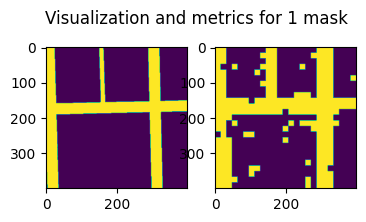

{'Accuracy': 0.8416,
 'Precision': 0.59402,
 'Recall': 0.97203,
 'F1-score': 0.7374}

In [417]:
print('Predicted mask average:', mask_predictions(scaler=identity(), model=vgg, n_patches=25*25, img_directory='data/training/images', 
                                                  gt_directory='data/training/groundtruth', dataset_size=10))
visualize_predicition(img=im, gt=im_gt_gs, scaler=identity(), model=vgg, n_patches=25*25)

Woo! ~88% Average F1-score, on a subset of the training images for compilation issues. Clearly ConvNets are the way to go. lovely days, we may try a LeNet for memes but VGG is nice.

##### LeNet

### ii)